# Partial Differential Equations solved using PINNs.


### 1. Defining a few functions and initial, boundaries, eqns and stuff.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn as nn

### 1. Defining the initial arrays of space and time.

In [ ]:
Nx = 20
Nt = 20
Nv = 20

k = 0.4
L = (2 * np.pi) / k

x = torch.linspace(0, L, Nx).view(-1, 1)  #[Nx]
v = torch.linspace(-6, 6, Nv).view(-1, 1) #[Nv]
t = torch.linspace(0, 25, Nt).view(-1, 1) #[Nt]

print(f"Shape of x : {x.shape} and t : {t.shape} and v : {v.shape}")


Shape of x : torch.Size([20, 1]) and t : torch.Size([20, 1]) and v : torch.Size([20, 1])


In [ ]:
# Meshes and vectors
X_train, v_train, t_train = torch.meshgrid(x.squeeze(), v.squeeze() ,t.squeeze(), indexing='xy')

X_train, v_train, t_train = X_train.reshape(-1, 1), v_train.reshape(-1, 1), t_train.reshape(-1, 1)

print(f"Shape of X_train : {X_train.shape} and t_train : {t_train.shape} and v_train : {v_train.shape}")

Shape of X_train : torch.Size([8000, 1]) and t_train : torch.Size([8000, 1]) and v_train : torch.Size([8000, 1])


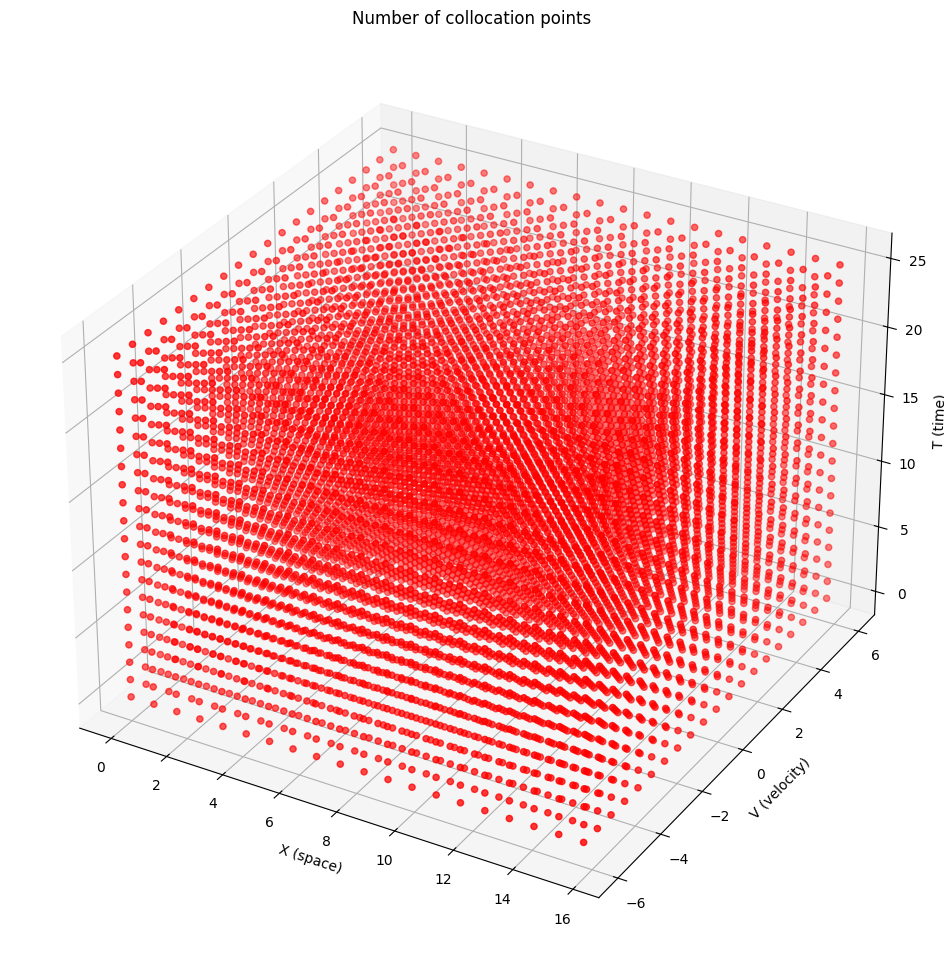

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train, v_train, t_train, c='r', marker='o')
ax.set_xlabel('X (space)')
ax.set_ylabel('V (velocity)')
ax.set_zlabel('T (time)')
ax.set_title('Number of collocation points')
plt.show()

### 2. Neural network architecture.

In [ ]:
class Q_PINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.SiLU

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer

    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())

    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x, v, t):
    inputs = torch.cat([x, v, t], dim=1)
    outputs = self.net(inputs)

    q = outputs

    return q


class EC_PINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.SiLU

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer

    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())

    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x, v, t):
    inputs = torch.cat([x, v, t], dim=1)
    outputs = self.net(inputs)

    EC = outputs

    return EC

### 3. Now defining the losses :
- The P.D.E loss
- The initial condition loss
- The boundary condition loss

In [ ]:
def q_pde_loss(q_pred, E_pred, x_train, v_train, t_train):
  """
  Vlassov : dQ_dt + (V * dQ_dx) + (a * dQ_dv) = 0
  IC : Q(x, v, t=0) = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x))
  BC : Q is periodic

  Finds physics loss based on the above equation.
  """
  dQ_dt = torch.autograd.grad(q_pred, t_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dx = torch.autograd.grad(q_pred, x_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dv = torch.autograd.grad(q_pred, v_train, torch.ones_like(q_pred), create_graph=True)[0]

  eqn = dQ_dt + (v_train * dQ_dx) - (E_pred * dQ_dv) #Vlassov

  return torch.mean(eqn**2)


def q_initial_condition_loss(q_pred, x, v, t, alpha = 0.01):
  initial_condition_Q = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x))

  return torch.mean((q_pred-initial_condition_Q) ** 2)


def q_boundary_condition_loss(qlb_pred, qup_pred, t):

  return torch.mean((qup_pred - qlb_pred) ** 2) # Periodic along x axis and v axis.

In [ ]:
def EC_pde_loss(EC_cap_pred, q_pred, x_train, v_train, t_train):
  """
  Poisson : dE_dx - integral(Q, dv) + 1 = 0
  IC : E(x, v, t=0) = (alpha/k) * torch.cos(k * x)
  BC : E is periodic

  Finds physics loss based on the above equation.
  """

  dE_dx = torch.autograd.grad(EC_cap_pred, x_train, torch.ones_like(EC_cap_pred), create_graph=True)[0]
  dE_dxdv = torch.autograd.grad(dE_dx, v_train, torch.ones_like(dE_dx), create_graph=True)[0]

  eqn = dE_dxdv + q_pred
  return torch.mean(eqn**2)


def EC_initial_condition_loss(EC_cap_pred, x, v, t, alpha = 0.01):
  initial_condition_E = (alpha/k) * torch.cos(k * x)

  return torch.mean((EC_cap_pred-initial_condition_E) ** 2)


def EC_boundary_condition_loss(elb_pred, eup_pred, t):

  return torch.mean((eup_pred-elb_pred) ** 2) # Periodic along x axis and v axis.

### 4. Writing the training loop.

In [ ]:
q_model = Q_PINN(3, 80, 5, 2)
q_optimiser = torch.optim.Adam(q_model.parameters(), lr = 0.01)

ec_model = EC_PINN(3, 80, 5, 2)
ec_optimiser = torch.optim.Adam(ec_model.parameters(), lr = 0.01)

epochs = 2

In [ ]:
X_train_Q = X_train.requires_grad_(True)
t_train_Q = t_train.requires_grad_(True)
v_train_Q = v_train.requires_grad_(True)

X_train_EC = X_train.requires_grad_(True)
t_train_EC = t_train.requires_grad_(True)

In [ ]:
TOTAL_LOSS_Q, TOTAL_LOSS_EC = [], []

for epoch in range(1, epochs+1):
  q_model.train()
  ec_model.train()

  q_optimiser.zero_grad()
  ec_optimiser.zero_grad()


  # Q MODEL PREDICTIONS
  # Initial Condition
  q_pred_init = q_model(x, v, torch.zeros_like(x)) # q,E(x, v, 0)
  ic_loss = q_initial_condition_loss(q_pred_init, x, v, torch.zeros_like(x))

  # Boundary Condition
  q_lb_pred1 = q_model(torch.full_like(t, 0), v, t) # q,E(0, v, t) - lower bound at x=0
  q_ub_pred1 = q_model(torch.full_like(t, L), v, t) # q,E(16, v, t) - upper bound at x=16
  bcloss1 = q_boundary_condition_loss(q_lb_pred1, q_ub_pred1, t)

  q_lb_pred2 = q_model(x, torch.full_like(t, -6), t) # q,E(x, -6, t) - lower bound at v=-6
  q_ub_pred2 = q_model(x, torch.full_like(t, 6), t) # q,E(x, 6, t) - upper bound at v=6
  bcloss2 = q_boundary_condition_loss(q_lb_pred2, q_ub_pred2, t)

  bc_loss = bcloss1 + bcloss2

  # Physics Condition
  q_pred, e_pred = model(X_train, v_train, t_train)
  physics_loss = pde_loss(q_pred, e_pred, X_train, v_train, t_train)

  # Total loss
  total_loss = physics_loss + 2 * ic_loss + bc_loss
  TOTAL_LOSS.append(total_loss.item())

  total_loss.backward()
  optimiser.step()

  if(epoch%1==0):
    print(f"[{epoch}/{epochs}] Losses - Total:{total_loss.item():.4f}, Physics:{physics_loss.item():.4f}, IC:{ic_loss.item():.4f}, BC:{bc_loss.item():.4f}")

[1/1000] Losses - Total:7.8765, Physics:7.7413, IC:0.0618, BC:0.0117
[2/1000] Losses - Total:31.7706, Physics:31.4947, IC:0.1321, BC:0.0117
[3/1000] Losses - Total:17.7718, Physics:17.5341, IC:0.1086, BC:0.0205
[4/1000] Losses - Total:6.1963, Physics:6.0626, IC:0.0631, BC:0.0074
[5/1000] Losses - Total:0.5513, Physics:0.5138, IC:0.0166, BC:0.0044
[6/1000] Losses - Total:4.4022, Physics:4.3256, IC:0.0323, BC:0.0120
[7/1000] Losses - Total:1.9465, Physics:1.8569, IC:0.0359, BC:0.0179
[8/1000] Losses - Total:0.1050, Physics:0.0259, IC:0.0280, BC:0.0232
[9/1000] Losses - Total:2.0394, Physics:1.9507, IC:0.0303, BC:0.0282
[10/1000] Losses - Total:3.1516, Physics:3.0542, IC:0.0340, BC:0.0293
[11/1000] Losses - Total:1.9032, Physics:1.8102, IC:0.0328, BC:0.0273
[12/1000] Losses - Total:0.4457, Physics:0.3538, IC:0.0324, BC:0.0272
[13/1000] Losses - Total:0.1235, Physics:0.0246, IC:0.0340, BC:0.0308
[14/1000] Losses - Total:0.5597, Physics:0.4542, IC:0.0353, BC:0.0349
[15/1000] Losses - Total:

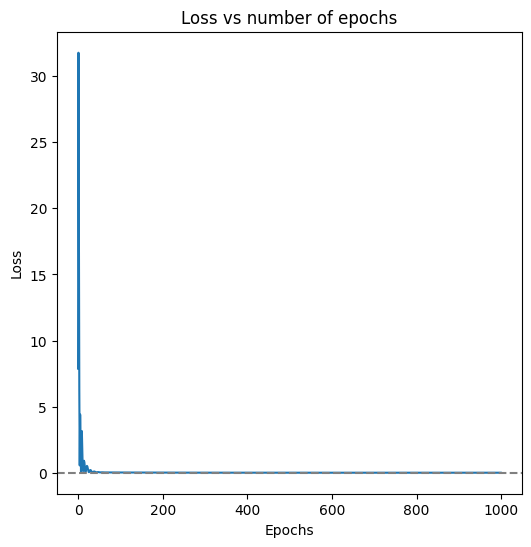

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(TOTAL_LOSS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(0.0, c='gray', linestyle='--')
plt.title('Loss vs number of epochs')
plt.show()

### 5. Testing the neural network.

In [ ]:
N_test = 25

In [ ]:
X_test = torch.linspace(0, L, N_test).view(-1, 1)
v_test = torch.linspace(-6, 6, N_test).view(-1, 1)
t_test = torch.linspace(0, 25, N_test).view(-1, 1)

X_test, v_test, t_test = torch.meshgrid(X_test.squeeze(), v_test.squeeze(),  t_test.squeeze(), indexing='xy')

X_test = X_test.reshape(-1, 1)
v_test = v_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)
print(f"Shape of X_test : {X_test.shape} and t_test : {t_test.shape} and v_test : {v_test.shape}")

Shape of X_test : torch.Size([15625, 1]) and t_test : torch.Size([15625, 1]) and v_test : torch.Size([15625, 1])


In [ ]:
model.eval()
with torch.no_grad():
  q_pred, e_pred = model(X_test, v_test, t_test)

In [ ]:
q_pred = q_pred.reshape(N_test, N_test, N_test)
e_pred = e_pred.reshape(N_test, N_test, N_test)
X_test = X_test.reshape(N_test, N_test, N_test)
v_test = v_test.reshape(N_test, N_test, N_test)
t_test = t_test.reshape(N_test, N_test, N_test)

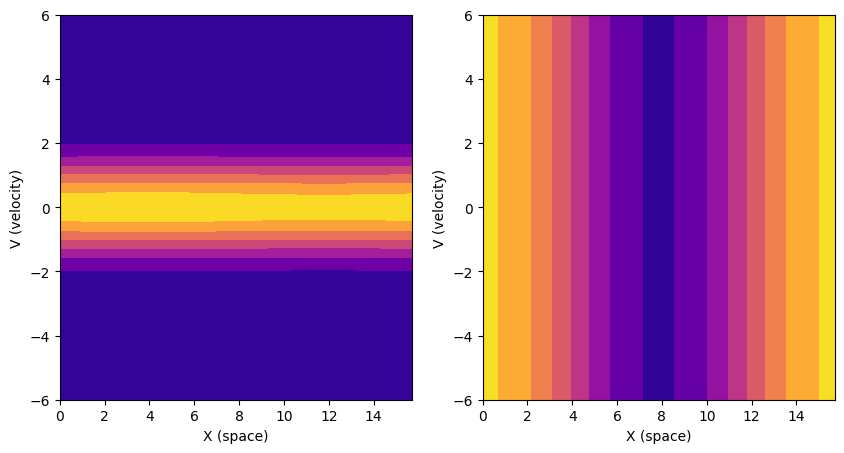

In [ ]:
# Initial conditions are defined here just to see what's going on.

alpha = 0.01
initial_condition_Q = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v_test**2)/2))  * (1 + alpha * torch.sin(k * X_test))      #No use of v or t here, this is the initial condition.
initial_condition_E = (alpha/k) * torch.cos(k * X_test)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].contourf(X_test[:, :, 0], v_test[:, :, 0], initial_condition_Q[:, :, 0], cmap='plasma')
ax[0].set_xlabel('X (space)')
ax[0].set_ylabel('V (velocity)')


ax[1].contourf(X_test[:, :, 0], v_test[:, :, 0], initial_condition_E[:, :, 0], cmap='plasma')
ax[1].set_xlabel('X (space)')
ax[1].set_ylabel('V (velocity)')

plt.show()

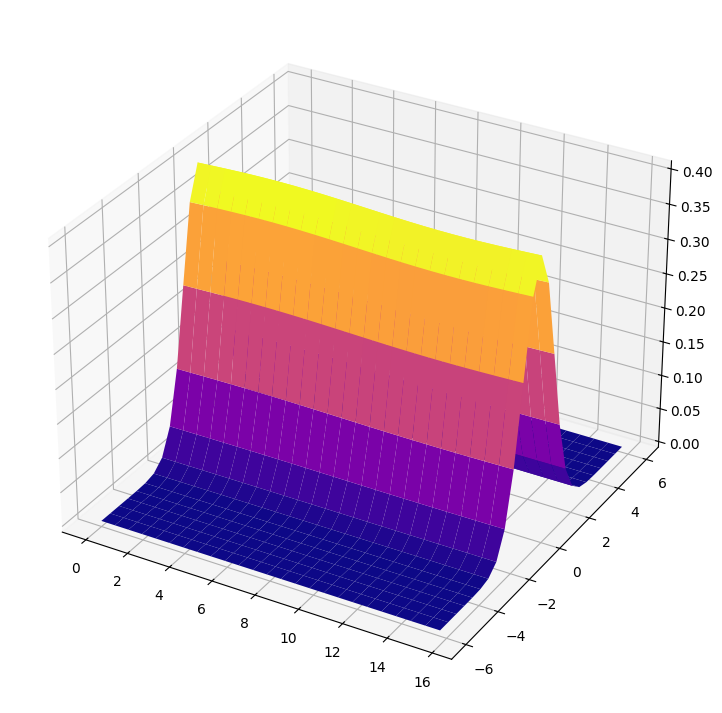

In [ ]:
# Surface plot of initial condition

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_surface(X_test[:, :, 0], v_test[:, :, 0], initial_condition_Q[:, :, 0], cmap='plasma')

# show plot
plt.show()

In [ ]:
q_pred = q_pred.numpy()
e_pred = e_pred.numpy()
X_test = X_test.numpy()
v_test = v_test.numpy()
t_test = t_test.numpy()

In [ ]:
print(f"Shape of q_pred, e_pred, x_test, v_test, t_test is {q_pred.shape}, {e_pred.shape}, {X_test.shape}, {v_test.shape} and {t_test.shape}")

Shape of q_pred, e_pred, x_test, v_test, t_test is (25, 25, 25), (25, 25, 25), (25, 25, 25), (25, 25, 25) and (25, 25, 25)


In [ ]:
time_slice = 0# Basically 3/10 = 0.3 seconds.

x_slice = X_test[:, :, time_slice]
v_slice = v_test[:, :, time_slice]
q_slice = q_pred[:, :, time_slice]
e_slice = e_pred[:, :, time_slice]

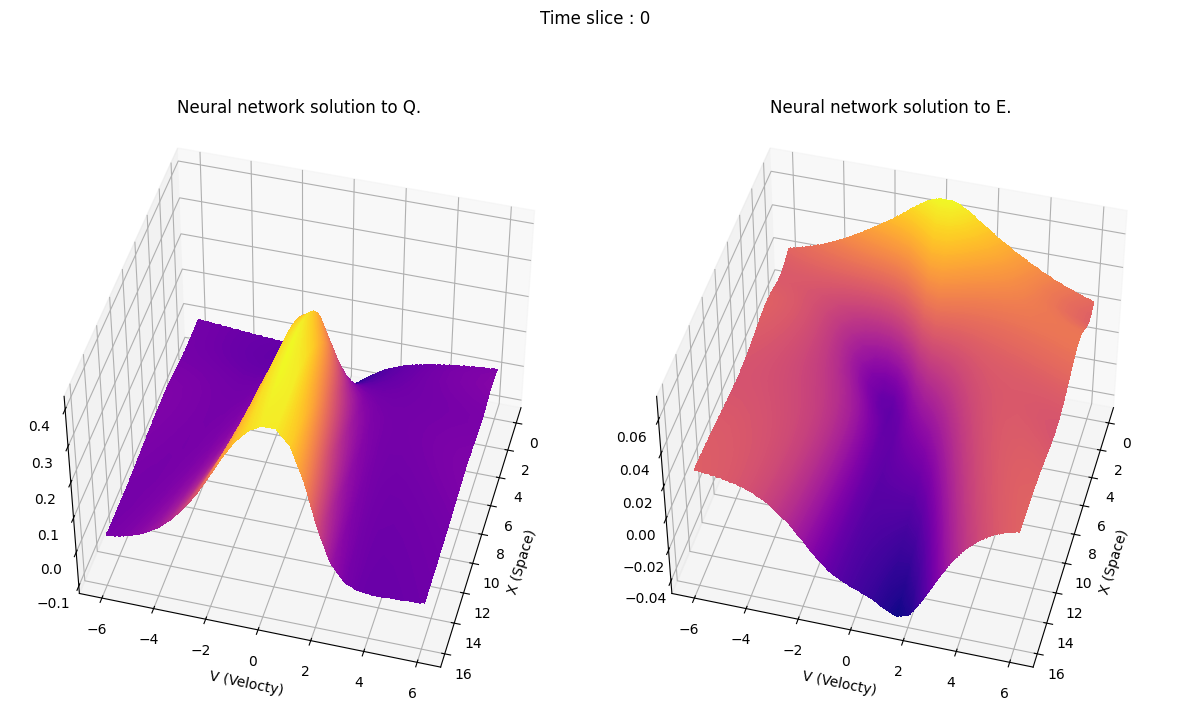

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.contourf(x_slice, v_slice, q_slice, levels=250, cmap='plasma')
ax1.set_xlabel('X (Space)')
ax1.set_ylabel('V (Velocty)')
ax1.set_title('Neural network solution to Q.')
ax1.view_init(elev=45, azim=15)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.contourf(x_slice, v_slice, e_slice, levels=250, cmap='plasma')
ax2.set_xlabel('X (Space)')
ax2.set_ylabel('V (Velocty)')
ax2.set_title('Neural network solution to E.')
ax2.view_init(elev=45, azim=15)

plt.suptitle(f"Time slice : {time_slice}")
plt.tight_layout()
plt.show()

In [ ]:
  e_slice = e_pred[0, 0, :]
t_slice = t_test[0, 0, :]
print("Shape of e and t is : ", e_slice.shape, t_slice.shape)

Shape of e and t is :  (25,) (25,)


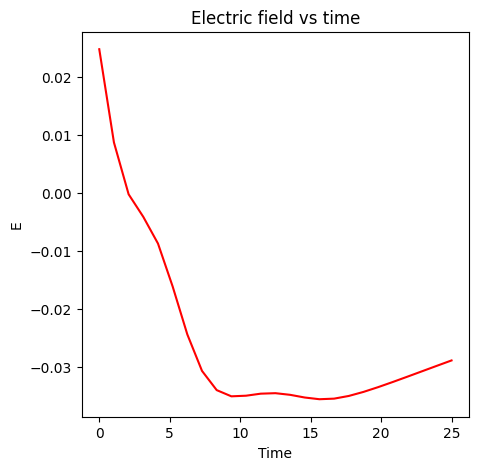

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(t_slice, e_slice, c='r')
plt.xlabel('Time')
plt.ylabel('E')
plt.title('Electric field vs time')
plt.show()